# Create CBECS datasets

In this notebook we clean and process the CBECS data into the "common feature" and "extended feature" datasets that we train and test models with.

These datasets are saved as ".npy" files in the `output/` directory.

In [1]:
%matplotlib inline
import sys
import os
import time
import math

import csv

import pickle

import pandas as pd
import numpy as np

from scipy.stats import mode, lognorm

from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

# Make directories

In [6]:
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print "(%s) already exists" % (path)

mkdir("results/")
mkdir("results/btuDistributions/")
mkdir("results/errorPlots/")
mkdir("results/formattedResults/")
mkdir("output/")
mkdir("output/nyc/")
mkdir("output/trainedModels/")

(results/) already exists
(results/btuDistributions/) already exists
(results/errorPlots/) already exists
(results/formattedResults/) already exists
(output/) already exists
(output/nyc/) already exists
(output/trainedModels/) already exists


# Load data from file

In [2]:
NAN = -2**31

RESULTS_DIR = "results/"
CBECS_DATA_FN = "data/cbecs/2012_public_use_data_aug2016.csv"

In [3]:
f = open(CBECS_DATA_FN,"r")
headerLine = f.readline().strip().split(",")
numColumns = len(headerLine)
f.close()

data = []
f = open(CBECS_DATA_FN,"r")
csvReader = csv.reader(f, delimiter=",", quotechar='"')
csvReader.next()
numRows = 0
for row in csvReader:
    for i in range(len(row)):
        #row[i] = row[i].replace(",","")
        if row[i]=="":
            row[i] = NAN
        row[i] = float(row[i])
    assert len(row)==numColumns
    data.append(row)
    numRows+=1
f.close()

data = np.array(data)

In [4]:
print data.shape

(6720, 1119)


In [5]:
xIndices = []
yIndices = []

columnNames = []

for i in range(numColumns):
    if headerLine[i] == "MFBTU":
        yIndices.append(i)
    elif "ZMFBTU" in headerLine[i]:
        xIndices.append(i)
        columnNames.append(headerLine[i])
    elif headerLine[i].startswith("Z"): #Checked, every feature that starts with a Z is an accessory variable that tells whether another variable was imputed, etc.
        pass
    elif headerLine[i].startswith("FINALWT"): #There is a finalwt feature for every other variable, these are unecessary
        pass
    elif i >= 1051: # don't keep data after MFBTU
        pass
    else:
        xIndices.append(i)
        columnNames.append(headerLine[i])

In [6]:
columnNames = np.array(columnNames)

X = data[:,xIndices]
Y = data[:,yIndices].flatten()

numberOfSamples = X.shape[0]
numberOfFeatures = X.shape[1]

# Remove rows where ZMBTU is not 2 or 9

In [7]:
columnToCheck = columnNames=="ZMFBTU"
checkVector = X[:,columnToCheck].flatten()
correctMask = np.where((checkVector!=2) & (checkVector!=9))

print X.shape,Y.shape
X = X[correctMask]
Y = Y[correctMask]
print X.shape,Y.shape

(6720, 449) (6720,)
(5099, 449) (5099,)


# Augment rows where NFLOOR is > 15

In [8]:
columnToCheck = columnNames=="NFLOOR"
checkVector = X[:,columnToCheck].flatten()
X[checkVector == 994, columnToCheck] = 20
X[checkVector == 995, columnToCheck] = 30
print X.shape,Y.shape

(5099, 449) (5099,)


# Eliminate features with over 25% missing values

In [9]:
percentNAN = []
for i in range(X.shape[1]):
    badVals = X[:,i] == NAN
    percentNAN.append(sum(badVals)/float(X.shape[0]))

In [10]:
DISCARD_THRESHOLD = 0.25

colMask = []
for val in percentNAN:
    if val > DISCARD_THRESHOLD: #if the percent of NANs is greater than threshold, we don't keep it
        colMask.append(False)
    else:
        colMask.append(True)

colMask = np.array(colMask)

X = X[:,colMask]
columnNames = columnNames[colMask]

# Replace missing values with most frequently occuring value

In [11]:
for i in range(X.shape[1]):
    badVals = X[:,i] == NAN
    X[badVals,i] = mode(X[~badVals,i]).mode[0] #replace bad vals column-wise with most frequent

# Visualize distribution of target values

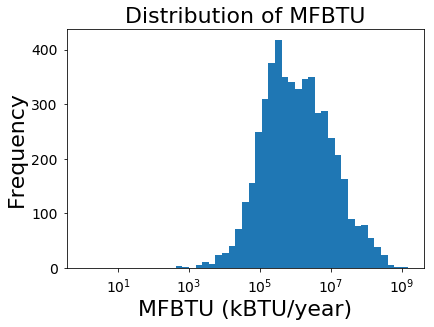

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
#plt.hist(absoluteErrors, bins=np.logspace(np.log10(1),np.log10(max(absoluteErrors)),50))

mu, sigma = Y.mean(), Y.std()

bins = np.logspace(np.log10(1),np.log10(Y.max()),50)

plt.hist(Y, bins=bins)

plt.xscale("log")

ax.set_title("Distribution of MFBTU", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("MFBTU (kBTU/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig(os.path.join(RESULTS_DIR, "MFBTU_allData.png"), dpi=150, alpha=True, bbox_inches='tight')
plt.show()
plt.close()

2.23197863016 -465.775558489 1138104.64988


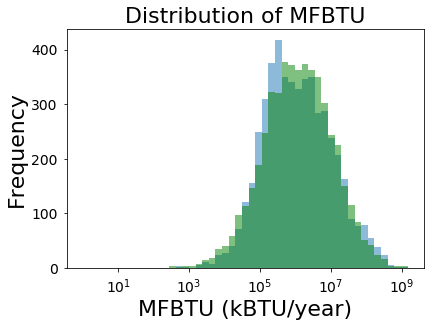

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))

mu, sigma = Y.mean(), Y.std()

s,loc,scale = lognorm.fit(Y)
distribution = lognorm(s=s, loc=loc, scale=scale)

print s,loc,scale

Y2 = distribution.rvs(Y.shape[0])

bins = np.logspace(np.log10(1),np.log10(Y.max()),50)

histValues, histBins, _ = plt.hist(Y, bins=bins, alpha=0.5)
plt.hist(Y2, bins=bins, color="green", alpha=0.5)

#plt.vlines(np.median(Y2),0,450)

ax.set_title("Distribution of MFBTU", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("MFBTU (kBTU/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.xscale("log")

plt.savefig(os.path.join(RESULTS_DIR, "MFBTU_dist_allData.png"), dpi=150, alpha=True, bbox_inches='tight')
plt.show()
plt.close()

# Save dataset

In [14]:
print X.shape
print Y.shape
print columnNames.shape

np.save("output/cbecs_X_MFBTU.npy", X)
np.save("output/cbecs_Y_MFBTU.npy", Y)
np.save("output/cbecs_headers_MFBTU.npy", columnNames)

numberOfSamples = X.shape[0]
numberOfFeatures = X.shape[1]

(5099, 179)
(5099,)
(179,)


# Create reduced feature set

In [15]:
columnsToKeep = ["PUBID", "PBA", "SQFT", "CDD65", "HDD65", "NFLOOR"]
columnIndicesToKeep = [np.where(columnNames == columnName)[0][0] for columnName in columnsToKeep]

newX = []
newY = []

for i in range(X.shape[0]):
    
    newFeatures = list(X[i,columnIndicesToKeep])
    
    newX.append(newFeatures)
    newY.append(Y[i])

newX = np.array(newX)
newY = np.array(newY)
columnsToKeep = np.array(columnsToKeep)

print newX.shape
print newY.shape
print columnsToKeep.shape

(5099, 6)
(5099,)
(6,)


In [16]:
np.save("output/cbecs_reduced_X_MFBTU.npy", newX)
np.save("output/cbecs_reduced_Y_MFBTU.npy", newY)
np.save("output/cbecs_reduced_headers_MFBTU.npy", columnsToKeep)

# Print Class Frequencies

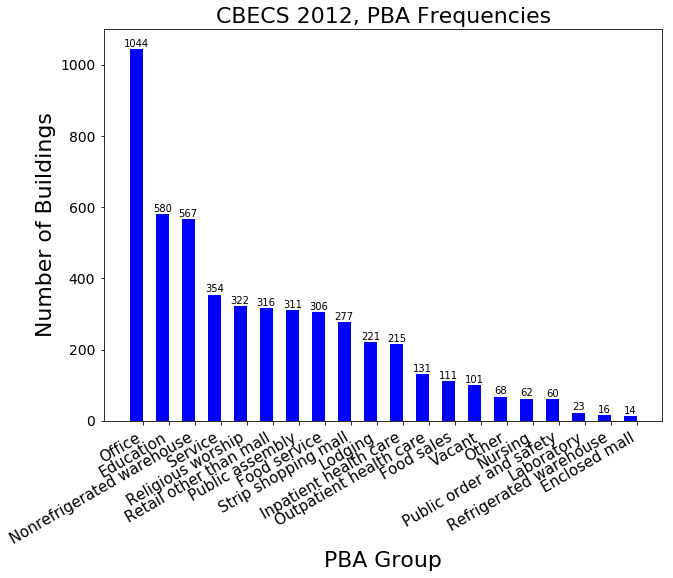

In [17]:
pbaLabels = {
    1 : 'Vacant',
    2 : 'Office',
    4 : 'Laboratory',
    5 : 'Nonrefrigerated warehouse',
    6 : 'Food sales',
    7 : 'Public order and safety',
    8 : 'Outpatient health care',
    11 : 'Refrigerated warehouse',
    12 : 'Religious worship',
    13 : 'Public assembly',
    14 : 'Education',
    15 : 'Food service',
    16 : 'Inpatient health care',
    17 : 'Nursing',
    18 : 'Lodging',
    23 : 'Strip shopping mall',
    24 : 'Enclosed mall',
    25 : 'Retail other than mall',
    26 : 'Service',
    91 : 'Other'
}

labels = newX[:,columnsToKeep=="PBA"].flatten()
classFrequencies = Counter(labels)

xLabels = sorted(classFrequencies, key=classFrequencies.get, reverse=True)
yVals = [classFrequencies[_] for _ in xLabels]

ind = np.arange(len(xLabels))
width = 0.5
fig, ax = plt.subplots(figsize=(10,8))

rects1 = ax.bar(ind+(width/2), yVals, width, color='b')

ax.set_title("CBECS 2012, PBA Frequencies", fontsize=22, color='k')
ax.set_ylabel("Number of Buildings", fontsize=22, color='k')
ax.set_xlabel("PBA Group", fontsize=22, color='k')
ax.set_xticks(ind + width)
ax.set_xticklabels([pbaLabels[_] for _ in map(int,xLabels)], fontsize=15, color='k')
ax.set_ylim([0,1100])
ax.tick_params(axis='y', which='major', labelsize=14)


fig.autofmt_xdate()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + 1,'%d' % int(height), ha='center', va='bottom')

autolabel(rects1)
plt.savefig(os.path.join(RESULTS_DIR, "PBA_Frequencies.png"), dpi=150, alpha=True, bbox_inches='tight')
plt.show()
plt.close()